<a href="https://colab.research.google.com/github/mobinapourmoshir/Functional-Deep-Learning/blob/main/Iris_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Building a multilayer perceptron for classifying flowers in the Iris dataset**

In [1]:
# Loadeing Iris data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [3]:
import torch
import numpy as np
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
# Standardizing the data
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train)
# Data set
train_ds = TensorDataset(X_train_norm, y_train)
# Data loader
torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [6]:
import torch.nn as nn
# Defining class of the model
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  # Layer 1
        self.layer2 = nn.Linear(hidden_size, output_size) # Layer 2

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x

input_size = X_train_norm.shape[1]
hidden_size = 16
output_size = 3

model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001
# Defining Loss function
loss_fn = nn.CrossEntropyLoss()
# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()

    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

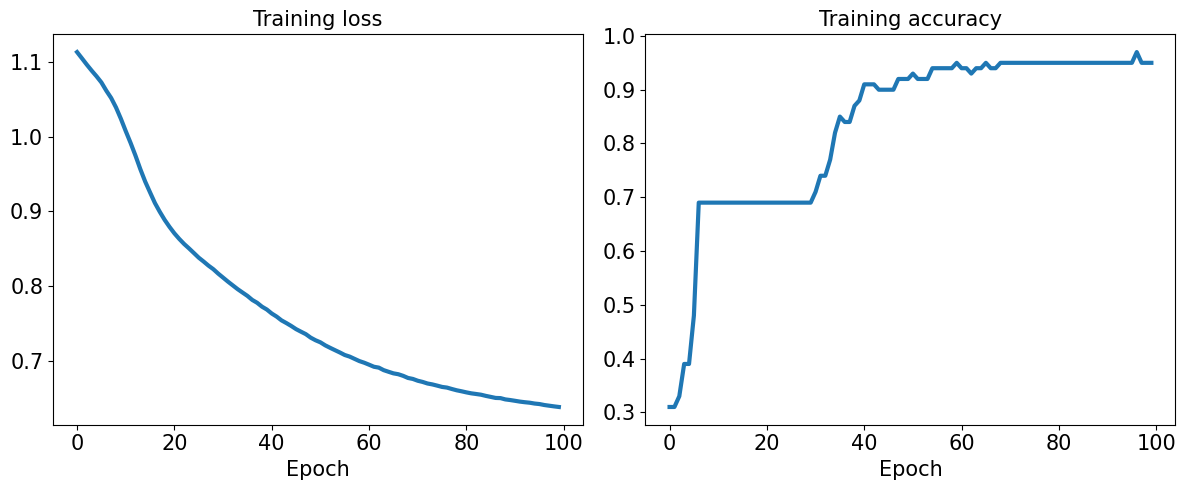

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')

plt.show()

### **Evaluating the trained model on the test dataset**

In [9]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test)
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()

print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


### **Saving and reloading the trained model**

In [11]:
#path = 'iris_classifier.pt'
#torch.save(model, path)
#model_new = torch.load(path)
#model_new.eval()

### **Confusion matrix**

[[17  0  0]
 [ 0  2 17]
 [ 0  0 14]]


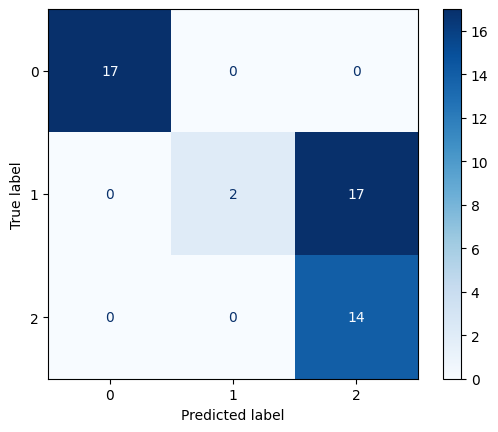

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# 1) Fit scaler on TRAIN ONLY (do this before training)
scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

# 2) Rebuild datasets/loaders (train and test should both be standardized)
torch_X_test = torch.from_numpy(X_test_std).float()
torch_y_test = y_test

test_ds = TensorDataset(torch_X_test, torch_y_test)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# 3) Evaluate
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        logits = model(xb)              # shape: (N, C)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)

ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.show()